<a href="https://colab.research.google.com/github/roydendsouza31/AI-Generated-Images-vs-Real-Images/blob/R3/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Generated Images vs Real Images

Creating the dataset

In [ ]:
#Creating folders to store the training and testing datasets
! mkdir -p /content/dataset_train/AIGenerated
! mkdir -p /content/dataset_train/Real
! mkdir -p /content/dataset_test/AIGenerated
! mkdir -p /content/dataset_test/Real

# **Getting the CIFAKE dataset**

In [ ]:
#Downloading the CIFAKE dataset from kaggle
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

import zipfile

# Define the path to your zip file
file_path = '/content/cifake-real-and-ai-generated-synthetic-images.zip'  # Replace 'your_file.zip' with your file's name

!mkdir CIFAKE

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/CIFAKE')  # Replace 'destination_folder' with your desired folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Moving the images from the CIFAKE dataset to their respective folders
!mv ./CIFAKE/train/FAKE/* ./dataset_train/AIGenerated
!rmdir /content/CIFAKE/train/FAKE
!mv ./CIFAKE/train/REAL/* ./dataset_train/Real
!rmdir /content/CIFAKE/train/REAL
!rmdir /content/CIFAKE/train

!mv ./CIFAKE/test/FAKE/* ./dataset_test/AIGenerated
!rmdir /content/CIFAKE/test/FAKE
!mv ./CIFAKE/test/REAL/* ./dataset_test/Real
!rmdir /content/CIFAKE/test/REAL
!rmdir /content/CIFAKE/test
!rmdir /content/CIFAKE

In [ ]:
import os
import random
import shutil

# Path to your AiGenerated and Real image folders
aigenerated_folder = "/content/dataset_train/AIGenerated"
real_folder = "/content/dataset_train/Real"

# Function to get the number of images in a folder
def count_images(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Function to delete 40% of the images in a folder
def reduce_folder_size(folder_path):
    num_images_before = count_images(folder_path)
    num_images_to_delete = int(num_images_before * 0.7)
    all_images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    images_to_delete = random.sample(all_images, num_images_to_delete)
    for image in images_to_delete:
        os.remove(os.path.join(folder_path, image))
    num_images_after = count_images(folder_path)
    print(f"Deleted {num_images_to_delete} images from {folder_path}")
    print(f"Number of images in {folder_path} before: {num_images_before}, after: {num_images_after}")

# Print the number of images in each folder before reducing the size
print(f"Number of images in {aigenerated_folder}: {count_images(aigenerated_folder)}")
print(f"Number of images in {real_folder}: {count_images(real_folder)}")

# Reduce the size of the AiGenerated and Real folders
reduce_folder_size(aigenerated_folder)
reduce_folder_size(real_folder)


Number of images in /content/dataset_train/AIGenerated: 71235
Number of images in /content/dataset_train/Real: 71208
Deleted 49864 images from /content/dataset_train/AIGenerated
Number of images in /content/dataset_train/AIGenerated before: 71235, after: 21371
Deleted 49845 images from /content/dataset_train/Real
Number of images in /content/dataset_train/Real before: 71208, after: 21363


In [ ]:
! pip install simple_image_download
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from simple_image_download import simple_image_download as simp
import random
import PIL
import pickle

In [ ]:
# response = simp.simple_image_download
# limit = 100

In [ ]:
# response().download("ai generated art", 100)
# response().download("ai generated images", 100)
# response().download("ai generated characters", 100)
# response().download('stable diffusion', 100)
# response().download('dalle2 generated images', 100)
# response().download('midjourney', 100)
# response().download('cityscapes', 100)
# response().download('animals', 100)
# response().download('vehicles', 50)
# response().download('traffic', 50)
# response().download('offices', 30)
# response().download('real food images', 50)
# response().download('landscape', 13)

In [ ]:
# !mv /content/simple_images/ai\ generated\ art/* /content/dataset_train/ai_generated
# !mv /content/simple_images/ai\ generated\ characters/* /content/dataset_train/ai_generated
# !mv /content/simple_images/ai\ generated\ images/* /content/dataset_train/ai_generated
# !mv /content/simple_images/dalle2\ generated\ images/* /content/dataset_train/ai_generated
# !mv /content/simple_images/midjourney/* /content/dataset_train/ai_generated
# !mv /content/simple_images/stable\ diffusion/* /content/dataset_train/ai_generated
# !mv /content/simple_images/animals/* /content/dataset_train/real
# !mv /content/simple_images/cityscapes/* /content/dataset_train/real
# !mv /content/simple_images/landscape/* /content/dataset_train/real
# !mv /content/simple_images/offices/* /content/dataset_train/real
# !mv /content/simple_images/real\ food\ images/* /content/dataset_train/real
# !mv /content/simple_images/traffic/* /content/dataset_train/real
# !mv /content/simple_images/vehicles/* /content/dataset_train/real

In [ ]:
# ! rm -r /content/simple_images
# ! rm -r sample_data

In [ ]:
data = "/content/dataset_train"
categories = ['Real', 'AIGenerated']

In [ ]:
import os

aigenerated_folder = "/content/dataset_train/AIGenerated"
for filename in os.listdir(aigenerated_folder):
    if ' ' in filename:
        os.rename(os.path.join(aigenerated_folder, filename), os.path.join(aigenerated_folder, filename.replace(' ', '_')))


In [ ]:
import os

real_folder = "/content/dataset_train/Real"
for filename in os.listdir(real_folder):
    if ' ' in filename:
        os.rename(os.path.join(real_folder, filename), os.path.join(real_folder, filename.replace(' ', '_')))


In [ ]:
img_size = 48
training_data = []

In [ ]:
for category in categories:
    path = os.path.join(data, category)
    classes = categories.index(category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv.imread(img_path)
        if img_array is not None:
            img_resized = cv.resize(img_array, (img_size, img_size))
            img_resized = img_resized / 255.0  # Normalize pixel values to [0, 1]
            training_data.append([img_resized, classes])
            print("Success")
        else:
            print(f"Failed to load image: \"{img_path}\"")

print(f"Total images processed: {len(training_data)}")

Streaming output truncated to the last 5000 lines.
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Succe

In [ ]:
len(training_data), training_data[0][0].shape

(38945, (48, 48, 3))

In [ ]:
random.shuffle(training_data)

In [ ]:
X_train = []
y_train = []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

In [ ]:
X_train.shape

(38945, 48, 48, 3)

In [ ]:
y_train.shape

(38945,)

In [ ]:
X_train[0].shape

(48, 48, 3)

In [ ]:
pickle_out = open("X_train.pickle", "wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

pickle_out = open("y_train.pickle", "wb")
pickle.dump(y_train, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
pickle_in = open("X_train.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

In [ ]:
X_train.shape

(38945, 48, 48, 3)

In [ ]:
y_train.shape

(38945,)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (48,48,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 64)        0

In [ ]:
history = model.fit(X_train, y_train, epochs=15)

Epoch 1/15
1218/1218 [==============================] - 15s 6ms/step - loss: 0.4929 - accuracy: 0.7597
Epoch 2/15
1218/1218 [==============================] - 8s 7ms/step - loss: 0.3689 - accuracy: 0.8392
Epoch 3/15
1218/1218 [==============================] - 7s 6ms/step - loss: 0.3076 - accuracy: 0.8699
Epoch 4/15
1218/1218 [==============================] - 8s 7ms/step - loss: 0.2732 - accuracy: 0.8856
Epoch 5/15
1218/1218 [==============================] - 8s 6ms/step - loss: 0.2559 - accuracy: 0.8956
Epoch 6/15
1218/1218 [==============================] - 8s 6ms/step - loss: 0.2423 - accuracy: 0.9008
Epoch 7/15
1218/1218 [==============================] - 8s 7ms/step - loss: 0.2299 - accuracy: 0.9056
Epoch 8/15
1218/1218 [==============================] - 7s 6ms/step - loss: 0.2215 - accuracy: 0.9114
Epoch 9/15
1218/1218 [==============================] - 8s 7ms/step - loss: 0.2111 - accuracy: 0.9139
Epoch 10/15
1218/1218 [==============================] - 7s 6ms/step - loss: 0.20

In [ ]:
model.save("AIGeneratedModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


KeyError: 'val_loss'

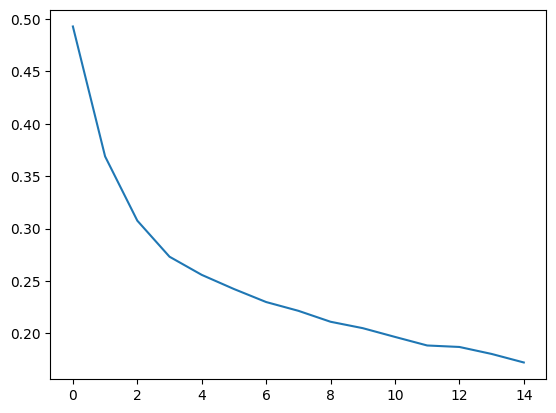

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and testing loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plot the training and testing accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [ ]:
model_new = keras.models.load_model("AIGeneratedModel.h5")

In [ ]:
data = "/content/dataset_test/"
categories = ['Real', 'AIGenerated']

img_size = 48
testing_data = []

i = 0
for category in categories:
    path = os.path.join(data,category)
    classes = categories.index(category)
    for img in os.listdir(path):
        i = i + 1
        img_array = cv.imread(os.path.join(path,img))
        new_array = cv.resize(img_array, (48,48))
        new_array = new_array/255
        testing_data.append([new_array, classes])

random.shuffle(testing_data)

X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [ ]:
model_new.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.2487 - accuracy: 0.8963


[0.24868422746658325, 0.8962500095367432]

In [ ]:
y_pred = model_new.predict(X_test)

625/625 [==============================] - 1s 2ms/step


In [ ]:
X_test.shape

(20000, 48, 48, 3)

In [ ]:
y_test.shape

(20000,)

In [ ]:
y_pred.shape

(20000, 1)

In [ ]:
y_predicted = []

for arr in y_pred:
    if arr[0] <= 0.5:
        y_predicted.append(0)
    else:
        y_predicted.append(1)

y_predicted = np.array(y_predicted)

In [ ]:
y_predicted.shape

(20000,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10000
           1       0.93      0.86      0.89     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



# Testing

In [ ]:
def find_out(path_img):
    img_arr = cv.imread(path_img)
    plt.imshow(img_arr)
    new_arr = cv.resize(img_arr, (48,48))
    new_arr = new_arr/255
    test = []
    test.append(new_arr)
    test = np.array(test).reshape(-1, img_size, img_size, 3)
    y = model_new.predict(test)
    if y[0] <= 0.5:
        print("The given image is Real.")
    else:
        print("The given image is AI Generated.")

1/1 [==============================] - 0s 121ms/step
The given image is AI Generated.


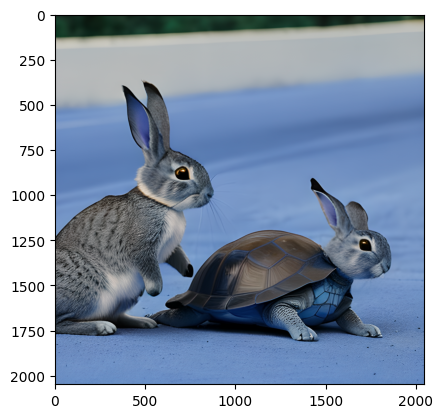

In [ ]:
path_img = '/content/testing/ai1.png'
find_out(path_img)

1/1 [==============================] - 0s 36ms/step
The given image is AI Generated.


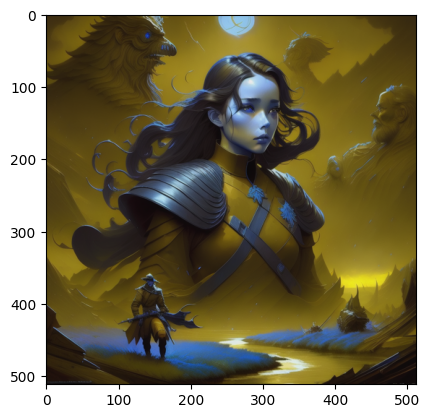

In [ ]:
path_img = '/content/testing/ai2.png'
find_out(path_img)

1/1 [==============================] - 0s 32ms/step
The given image is AI Generated.


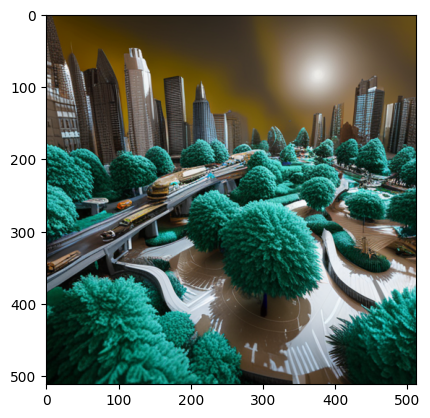

In [ ]:
path_img = '/content/testing/ai3.png'
find_out(path_img)

1/1 [==============================] - 0s 27ms/step
The given image is AI Generated.


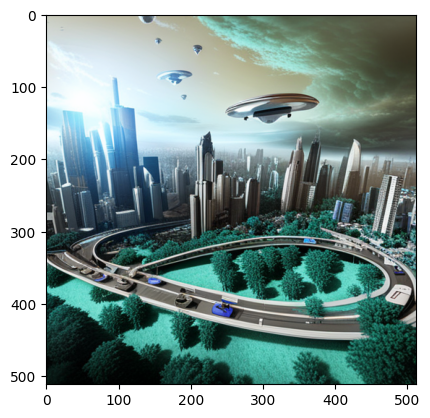

In [ ]:
path_img = '/content/testing/ai4.png'
find_out(path_img)

1/1 [==============================] - 0s 33ms/step
The given image is AI Generated.


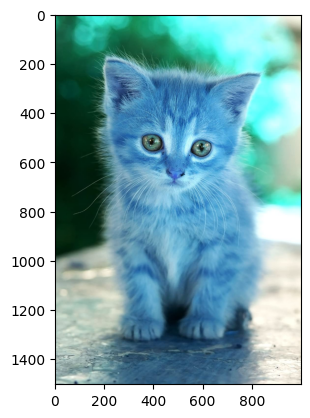

In [ ]:
path_img = '/content/testing/real2.jpeg'
find_out(path_img)

1/1 [==============================] - 0s 27ms/step
The given image is AI Generated.


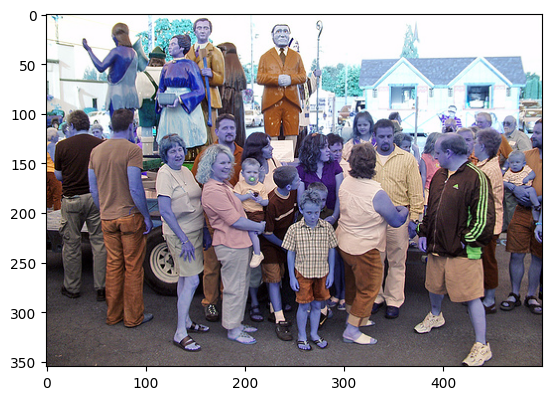

In [ ]:
path_img = '/content/testing/real3.jpg'
find_out(path_img)